![banner](/home/tahnik/aws-sagemaker-studio1/Training-and-Deploying-Model-with-Amazon-SageMaker-Studio1/poridhi-notebook-banner-sagemaker2.gif)

# Deploy and test a model

#### Fetch the newly trained model stored in the model artifacts store ⬇️

In [ ]:
import boto3
from sagemaker import get_execution_role
from sagemaker.s3 import S3Downloader
import tarfile

# Get the execution role
role = get_execution_role()

# Specify the S3 bucket and key where the model is stored
bucket = 'your_bucket_name'
key = 'model.tar.gz'

# Download the model from S3
S3Downloader.download(s3_uri=f's3://{bucket}/{key}', local_path='./model.tar.gz')

# Extract the model from the tar file
with tarfile.open('./model.tar.gz', 'r:gz') as tar:
    tar.extractall('./')

# Load the model
xgb = tar.getmember('model.bin')


#### Deploy the trained model ⬇️

In [20]:
from sagemaker.serializers import CSVSerializer

xgb_predictor = xgb.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-07-15-17-08-15-805
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-07-15-17-08-15-805
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-07-15-17-08-15-805


------------------!

#### You can observe in the console that the model has been deployed
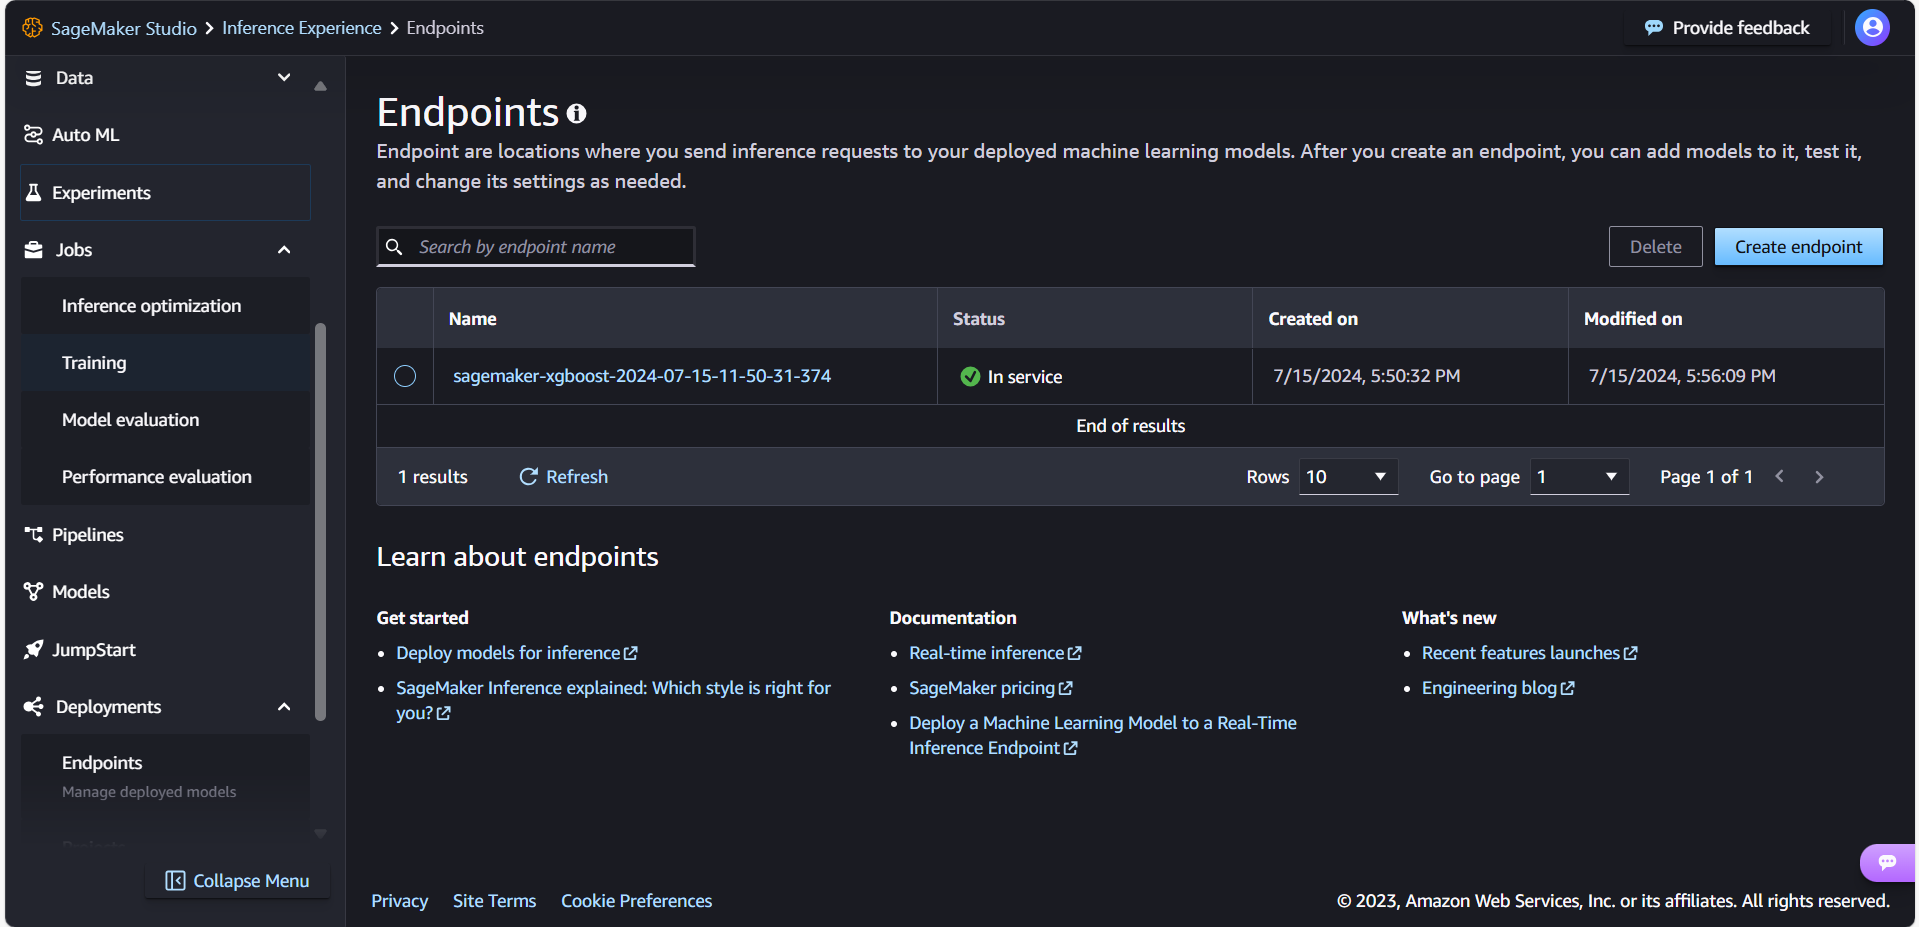


#### Open the endpoint and observe its components,
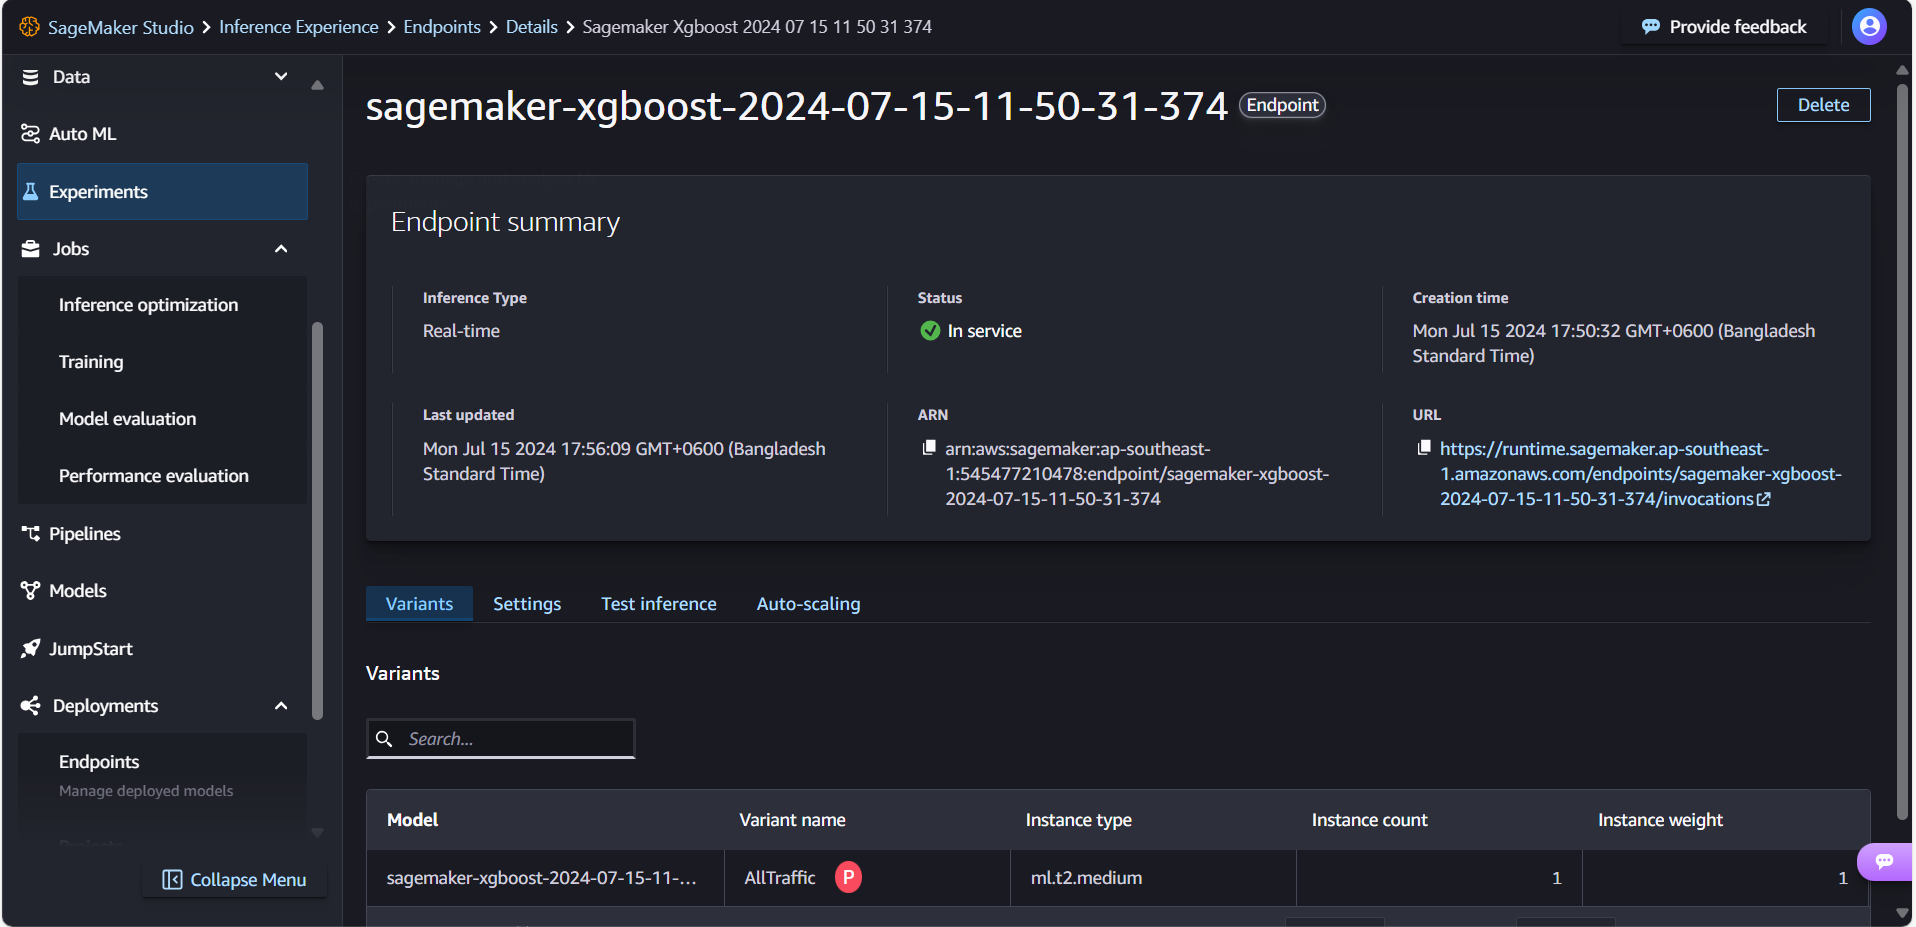

### Extract attributes and target values 🎯

In [28]:
boolean_columns = churn_df_test.select_dtypes(include=['bool']).columns

In [30]:
churn_df_test[boolean_columns] = churn_df_test[boolean_columns].astype(int)

In [31]:
churn_np_test = churn_df_test.to_numpy()

In [32]:
actual = churn_np_test[:, 0]

In [33]:
attributes = churn_np_test[:, 1:]

### Use a model on the test set 🪛

In [34]:
attributes

array([[114.        ,   0.        ,   0.50664522, ...,   1.        ,
          1.        ,   0.        ],
       [124.        ,   0.        ,   8.25109717, ...,   1.        ,
          1.        ,   0.        ],
       [189.        ,   0.        ,   3.80580833, ...,   0.        ,
          1.        ,   0.        ],
       ...,
       [ 42.        ,   0.        ,   7.11483611, ...,   0.        ,
          1.        ,   0.        ],
       [ 62.        , 200.        ,   3.148166  , ...,   0.        ,
          0.        ,   1.        ],
       [179.        ,   0.        ,   2.54804744, ...,   0.        ,
          1.        ,   0.        ]])

In [54]:
res = xgb_predictor.predict(attributes[0]).decode('utf-8')
res

'0.0001070175931090489\n'

In [55]:
for i in range(0, 100):
    res = xgb_predictor.predict(attributes[0]).decode('utf-8')

In [36]:
results = xgb_predictor.predict(attributes).decode('utf-8')

## Calculate accuracy 🔢

In [37]:
predictions_str = results.split('\n')[:-1]
predictions = [float(res_str) for res_str in predictions_str]

In [ ]:
p

In [38]:
from sklearn.metrics import accuracy_score
accuracy_score(actual, np.round(predictions))

0.945

# Delete deployed endpoint

In [ ]:
xgb_predictor.delete_endpoint()